## Анализ новой механики оплат услуг

### 1.1 Задача

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

| <p style="text-align: center; font-size:14px;"> Название файла </p>  | <p style="text-align: center; font-size:14px;"> Описание </p> |
| ------------- | ------------- |
| <span style="font-size:14px;">groups.csv</span>  | <p style="text-align: left; font-size:14px;"> файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) </p>  |
| <span style="font-size:14px;">groups_add.csv</span>  | <p style="text-align: left; font-size:14px;"> дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных </p>  |
| <span style="font-size:14px;">active_studs.csv</span>  | <p style="text-align: left; font-size:14px;"> файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента </p>  |
| <span style="font-size:14px;">checks.csv</span>  | <p style="text-align: left; font-size:14px;"> файл с информацией об оплатах пользователей в дни проведения эксперимента </p>  |

### 1.3 Задача

Расчёт ключевых метрик (CR, ARPU, ARPPU).  
Проведение A/B - тестовю  
Сделать вывод распространять ли новую механику оплаты услуг на всех клиентов.  


---

### План выполнения

1. Подключение библиотек и настройка отображения графиков
2. Чтение и предварительный анализ данных   
3. Расчёт метрик  
4. Статистические тесты   
5. Визуализация метрик   
6. Дополнительное исследование на предмет различия оплат в группах 
7. Выводы 
8. Функция пересчета метрик при получении доп. данных <Бонус>


### 1. Подключение библиотек и настройка отображения графиков

In [1]:
# Подключение библиотек

%matplotlib inline

import pandas as pd
import numpy as np
from itertools import combinations

import requests 
from urllib.parse import urlencode 

import seaborn as sns
import matplotlib.pyplot as plt

# Z-тест для разности долей
from statsmodels.stats.proportion import proportions_ztest

# levene - для проверки гомогенности (равенства) дисперсий
from scipy.stats import levene, ttest_ind  

In [2]:
# Настройка отображения графиков
size = 14
params = {
    "legend.fontsize": "large",
    "axes.titlesize": size,
}
plt.rcParams.update(params)

---

### 2. Чтение и предварительный анализ данных  

__2.1 Чтение данных в датафреймы__

In [3]:
# Функция для считывания информации из файла на Яндекс Диске в датафрейм
def read_file_yandex_dick(public_key, delimeter):
    base_url = "https://cloud-api.yandex.net/v1/disk/public/resources/download?"

    # получаем url
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()["href"]

    # загружаем файл в df
    download_response = requests.get(download_url)
    return pd.read_csv(download_url, sep=delimeter)

In [4]:
# Считываем датасеты в датафреймы
groups_df = read_file_yandex_dick("https://disk.yandex.ru/d/UhyYx41rTt3clQ", ";")
active_studs_df = read_file_yandex_dick("https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ", " ")
checks_df = read_file_yandex_dick("https://disk.yandex.ru/d/pH1q-VqcxXjsVA", ";")

__2.2 Данные о принадлежности пользователей к группам (groups)__

(А – контроль, B – целевая группа) 

In [5]:
groups_df.head(3)

,id,grp
0,1489,B
1,1627,A
2,1768,B


In [6]:
# Переименуем атрибут grp в group для удобства
groups_df = groups_df.rename(columns={"grp": "group"})

In [7]:
# Вывод информации о датафрейме (отсутствующие значения, типы данных)
groups_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   group   74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
# Посмотрим на количество уникальных значений
groups_df.nunique()

id       74484
group        2
dtype: int64

Количество уникальных значений id совпадает с количеством записей, значит дубли отсутствуют.

In [9]:
# Количество участников в группах
groups_df.group.value_counts()

group
B    59813
A    14671
Name: count, dtype: int64

In [10]:
# Соотношение участников групп
groups_df.group.value_counts(normalize=True)

group
B    0.803032
A    0.196968
Name: proportion, dtype: float64

Тестовую группу делают в 4 раза больше контрольной, когда необходимо увеличить статистическую мощность эксперимента для обнаружения более мелких эффектов или различий между группами.  
Увеличение размера тестовой группы позволяет уменьшить дисперсию и увеличить точность оценки эффекта влияния тестируемого фактора.

__2.3 Данные по активным студентам (active_studs)__

In [11]:
active_studs_df.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [12]:
# Количество активных
active_studs_df.shape

(8341, 1)

In [13]:
# Количество уникальных
active_studs_df.nunique()

student_id    8341
dtype: int64

id студентов идут не по возрастанию. Скорее всего по времени захода на платформу.

Из 74484 участников в группах, в логе заходов на платформу лишь 8341 участников (примерно 11%).

Далее считаю критерием попадания в контрольную или тестовую группы - действием не требующих особого усилия (отклик на письмо, регистрация, заход), а студентов из active_studs.csv как "активных", то есть выполнивших определенное действие (возможно, что помимо захода на платформу, также и решение N заданий).

__2.4 Данные об оплатах пользователей в дни проведения эксперимента (checks)__

In [14]:
checks_df.head(3)

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0


In [15]:
checks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [16]:
checks_df.student_id.nunique()

541

In [17]:
checks_df.describe()

,student_id,rev
count,5.410000e+02,541.000000
mean,2.514772e+06,1059.752317
std,1.726839e+06,762.712359
min,1.627000e+03,199.000000
25%,9.871290e+05,290.000000
50%,2.526021e+06,840.000000
75%,3.993249e+06,1900.000000
max,5.740903e+06,4650.000000


Метрики описательной статистики без дробной части, но тип столбца float64.  
Найдем значения с дробной частью.

In [18]:
# Создадим временный датафрейм для сохранности данных
temp_df = checks_df.copy()


# Функция для проверки наличия дробной части у числа
def has_decimal(number):
    return number % 1 != 0


# Применяем функцию к столбцу 'Numbers' и создаем новый столбец 'Has Decimal'
temp_df["Has Decimal"] = checks_df["rev"].apply(has_decimal)

# Фильтруем датафрейм по значениям в столбце 'Has Decimal'
numbers_with_decimal = temp_df[temp_df["Has Decimal"] == True]["rev"].unique()

print(f"Числа с дробной частью: {numbers_with_decimal}")

Числа с дробной частью: [1900.0001]


Присутствует только один вариант чисел с плавающей запятой, который дублирует такое же целое значение (1900).  
Появление данного варианта может быть вызвано разными причинами: проблемы с округлением, ввод данных из различных источников, использование различных типов данных и прочее

In [19]:
# Преобразуем столбец в целочисленный тип данных
checks_df["rev"] = checks_df.rev.astype(int)

<Axes: xlabel='rev'>

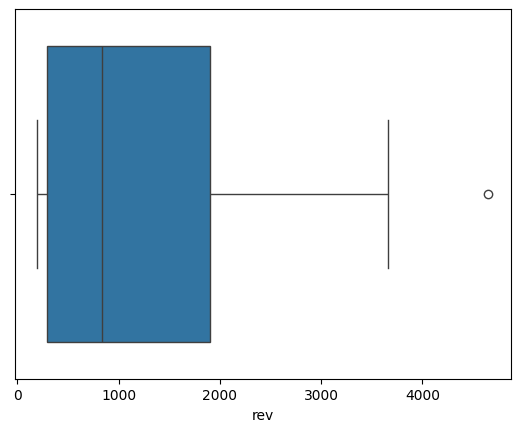

In [20]:
# Визуализируем распределение сумм покупок через боксплот
sns.boxplot(data=checks_df, x="rev")

541 клиент.  
В колонке "rev" - общая сумма по клиенту.  
Присутствует 1 не критичный выброс.

__2.5 Объединение данных в один датафрейм__

In [21]:
# объеиняем датафреймы принадлежности участников к группам
# и активных участников во временный датафрейм
temp_df = pd.merge(
    groups_df, active_studs_df, how="left", left_on="id", right_on="student_id"
).rename(
    columns={"student_id": "active"}
)  # переименуем столбец

# вместо бывшего student_id из датафрейма активности сделаем признак активен / не активен
temp_df["active"] = temp_df["active"].notnull().astype(int)

# объединяем полученный датафрейм с датафреймом оплат пользователей
united_df = (
    pd.merge(temp_df, checks_df, how="left", left_on="id", right_on="student_id")
    .fillna(0)
    .drop("student_id", axis=1)
)
united_df

,id,group,active,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0
...,...,...,...,...
74479,5692459,B,0,0.0
74480,5692572,B,0,0.0
74481,5692865,B,0,0.0
74482,5693667,B,0,0.0


---

### 3. Расчёт метрик


In [22]:
# ===== Промежуточные параметры =====

# Подсчет участников групп
A_team_users = united_df.query("group == 'A'").shape[0]
B_team_users = united_df.query("group == 'B'").shape[0]

# Считаем клиентов в группах
A_team_clients = united_df.query("group == 'A' & rev > 0")
B_team_clients = united_df.query("group == 'B' & rev > 0")

# Количество активных участников групп
active_A = united_df.query("group == 'A' & active == 1")
active_B = united_df.query("group == 'B' & active == 1")


# ===== Метрики =====

# Кол-во участников посчитано выше

# Конверсия участник - клиент
CR_user_A_to_client = round(A_team_clients.shape[0] * 100 / A_team_users, 2)
CR_user_B_to_client = round(B_team_clients.shape[0] * 100 / B_team_users, 2)

# Конверсия акт. участник - клиент
CR_active_A_to_client = round(A_team_clients.shape[0] * 100 / active_A.shape[0], 2)
CR_active_B_to_client = round(B_team_clients.shape[0] * 100 / active_B.shape[0], 2)

# ARPU
ARPU_A = round(A_team_clients.rev.sum() / A_team_users, 2)
ARPU_B = round(B_team_clients.rev.sum() / B_team_users, 2)

# ARPAU
ARPAU_A = round(A_team_clients.rev.sum() / active_A.shape[0], 2)
ARPAU_B = round(B_team_clients.rev.sum() / active_B.shape[0], 2)

# ARPPU
ARPPU_A = round(A_team_clients.rev.mean(), 2)
ARPPU_B = round(B_team_clients.rev.mean(), 2)

In [23]:
# Создание пустого датафрейма с необходимыми именами столбцов и индексов

# Список с именами столбцов
columns = ["Users", "CR users🠖clients", "CR active🠖clients", "ARPU", "ARPAU", "ARPPU"]
# Список с индексами
index = ["control", "target"]

result_df = pd.DataFrame(columns=columns, index=index)


# добавление метрик в результирующий датафрейм (итоговую таблицу)
result_df.loc["control"] = [
    A_team_users,
    CR_user_A_to_client,
    CR_active_A_to_client,
    ARPU_A,
    ARPAU_A,
    ARPPU_A,
]
result_df.loc["target"] = [
    B_team_users,
    CR_user_B_to_client,
    CR_active_B_to_client,
    ARPU_B,
    ARPAU_B,
    ARPPU_B,
]
result_df

,Users,CR users🠖clients,CR active🠖clients,ARPU,ARPAU,ARPPU
control,14671,0.73,6.97,6.28,60.0,860.71
target,59813,0.72,6.37,8.01,70.56,1107.0


---

### 4. Статистические тесты

Проведем тесты, чтобы проверить влияние новой механики оплат:  

1) сравненим конверсии из пользователя в клиента в группах с помощью Z-теста для разности долей  
2) t-тест на равенство средних значений сумм оплат клиентов в группах (ARPPU)  

Причины выбора ARPPU, а не на ARPU:
- "механика оплаты" относится больше к клиентам, чем к пользователям  
- минимальная разница конверсии в группах  
- всего 1 выброс, отрыв которого не критичен  
- достаточное количество клиентов.


__4.1 Сравнение конверсий из пользователя в клиента__

В данном случае имеется две независимые выборки разной численности.   
Для поределения есть ли статистически значимые различия в конверсиях между двумя группами, можно использовать Z-тест для разности долей.

Нулевая гипотеза (H0):  
Конверсии из пользователей в клиенты для двух групп одинаковы, то есть разница между долями конверсий равна нулю.  
Альтернативная гипотеза (H1):   
Конверсии из пользователей в клиенты для двух групп различаются, то есть разница между долями конверсий не равна нулю.

In [24]:
# Количество посетителей и количество клиентов в каждой группе
users_A = united_df.query("group == 'A'").shape[0]
users_B = united_df.query("group == 'B'").shape[0]
clients_A = united_df.query("group == 'A' & rev>0").shape[0]
clients_B = united_df.query("group == 'B' & rev>0").shape[0]

# Выполняем Z-тест для разности долей
stat, pval = proportions_ztest([clients_A, clients_B], [users_A, users_B])

# Выводим результаты теста
print(f"Z-статистика: {stat}")
print(f"p-значение: {pval} \n")

if pval < 0.05:
    print("Различия в конверсиях статистически значимы")
else:
    print("Нет статистически значимых различий в конверсиях")

Z-статистика: 0.06917886071597228
p-значение: 0.9448472494939772 

Нет статистически значимых различий в конверсиях


__4.2 Сравнение равенства средних значений сумм оплат клиентов в группах (ARPPU)__

Для этой задачи будем использовать t-тест.

Необходимые критерии:   
+ наблюдения независимы  
+ плотность распределения не является нормальной ИЛИ выборка достаточного размера (выполнена 2-я часть условия)  
- гомогенность дисперсий. Необходимо проверить. Если дисперсии не гомогенны, то будем применять поправку Уэлча.  

Для данного теста дисбаланс выборок не критичен.

__Проверка гомогенности (равенства) дисперсий тестом Левена__

Нулевая гипотеза (H0):   
Дисперсии во всех группах равны, то есть нет статистически значимых различий между дисперсиями.  
Альтернативная гипотеза (H1):  
Дисперсии во всех группах различны, то есть существуют статистически значимые различия между дисперсиями. 

In [25]:
# проверка гомогенности (равенства) дисперсий тестом Левена
control_group = united_df.query("group == 'A' & rev>0").rev
test_group = united_df.query("group == 'B' & rev>0").rev

# Применение теста Левена
statistic, p_value = levene(control_group, test_group)

# Вывод результатов
print(f"Статистика теста Левена: {statistic}")
print(f"p-значение: {p_value} \n")

if p_value < 0.05:
    print("Отвергаем нулевую гипотезу о гомогенности дисперсий.")
else:
    print("Нет оснований отвергать нулевую гипотезу.")

Статистика теста Левена: 4.099799301895542
p-значение: 0.043381707065155026 

Отвергаем нулевую гипотезу о гомогенности дисперсий.


__T-тест Стьюдента с поправкой Уэлча__

Нулевая гипотеза (H0):  
Средние значения в двух группах равны, то есть нет статистически значимого различия между средними значениями.  
Альтернативная гипотеза (H1):  
Средние значения в двух группах различны, то есть существует статистически значимое различие между средними значениями.


In [26]:
# Проведение одностороннего t-теста Стьюдента с поправкой Уэлча
t_stat, p_value = ttest_ind(control_group, test_group, equal_var=False)

# Вывод результатов
print(f"Статистика t-теста: {statistic}")
print(f"p-значение: {p_value} \n")

alpha = 0.05

if p_value < alpha and t_stat > 0:
    print(
        "Среднее значение в контрольной группе статистически значимо больше, чем в тестовой группе"
    )
elif p_value < alpha and t_stat < 0:
    print(
        "Среднее значение в контрольной группе статистически значимо меньше, чем в тестовой группе"
    )
else:
    print("Нет статистически значимого различия между средними значениями двух выборок")

Статистика t-теста: 4.099799301895542
p-значение: 0.005046700207344717 

Среднее значение в контрольной группе статистически значимо меньше, чем в тестовой группе


#### Вывод по тестам:

При отсутствии статистически значимых различий в конверсиях имеем существенный прирост в ARPPU от внедрения новой механики оплаты.  

---

### 5. Визуализация метрик  

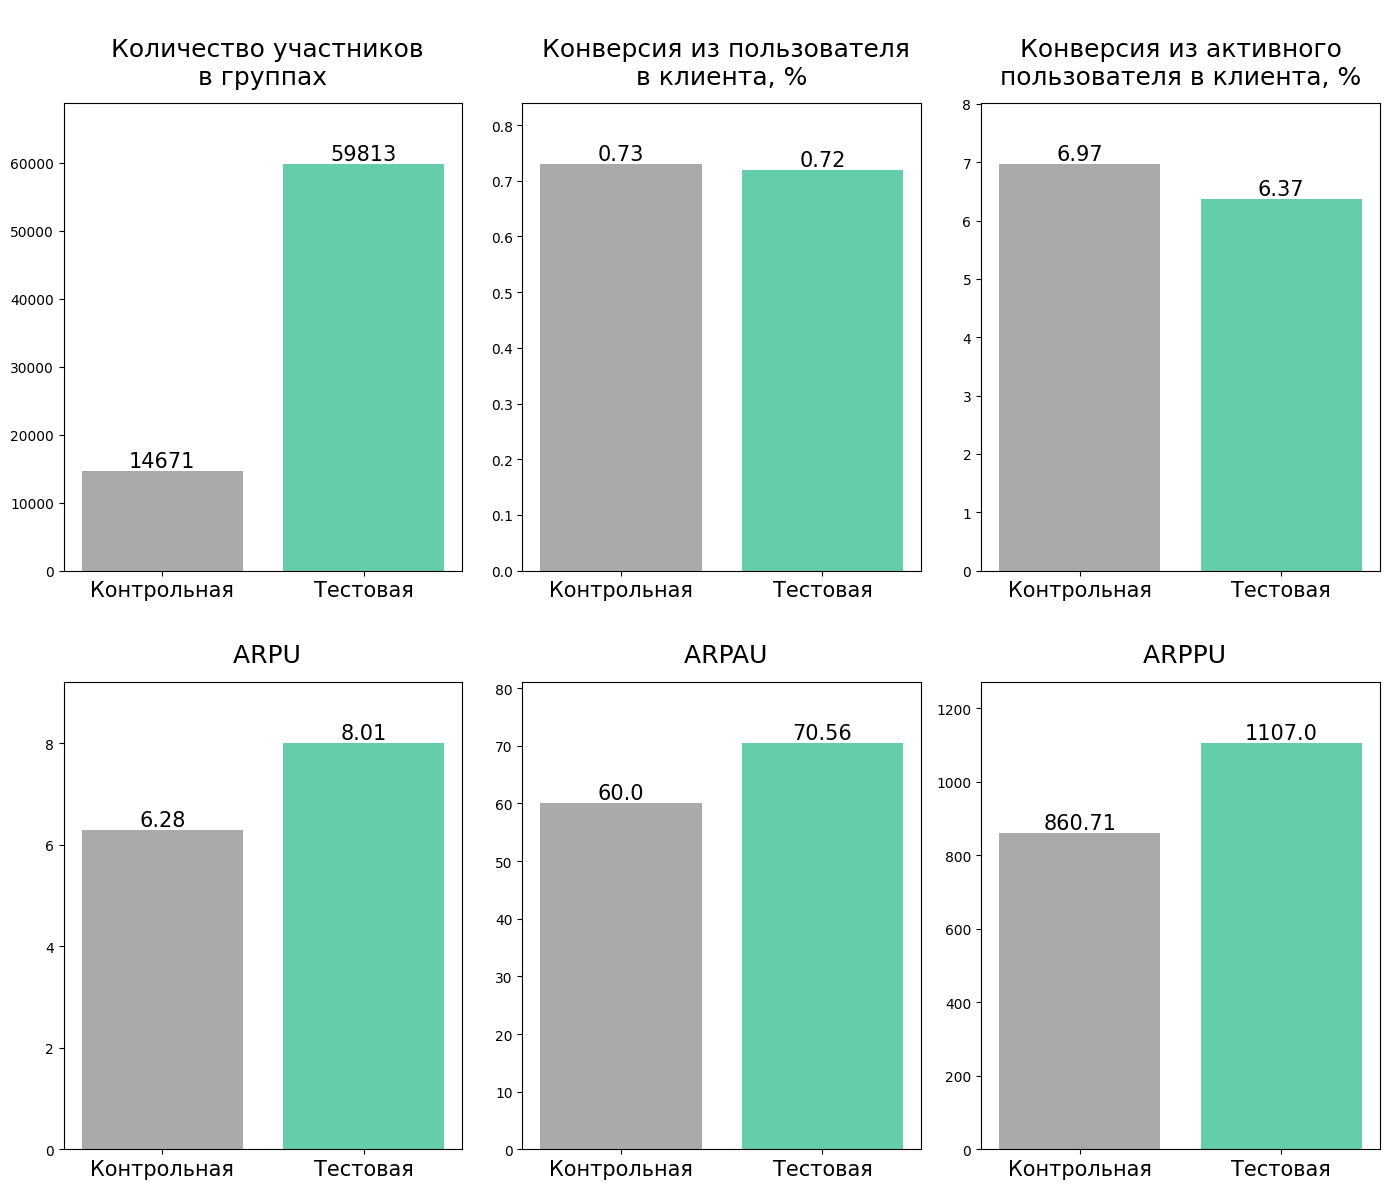

In [27]:
# Подтягиваем данные для графиков из итоговой таблицы с метриками
control_group = result_df.iloc[0, :].tolist()
test_group = result_df.iloc[1, :].tolist()

metrics = [
    "\n Количество участников\n в группах ",
    "\n Конверсия из пользователя\n в клиента, % ",
    "\n Конверсия из активного \nпользователя в клиента, %",
    "\n ARPU",
    "\n ARPAU",
    "\n ARPPU",
]

# Создаем 6 графиков расположенных 3x2
fig, axs = plt.subplots(2, 3, figsize=(14, 12))
# Добавляем расстояние между subplots
plt.subplots_adjust(hspace=3, wspace=1.2)

# size = 14

for i in range(6):
    row = i // 3
    col = i % 3
    x = np.arange(2)  # задания позиций столбцов на графике
    axs[row, col].bar(x, [control_group[i], test_group[i]], color=["#aaa", "#66CDAA"])
    axs[row, col].set_title(metrics[i], fontsize=size + 4, pad=14)
    axs[row, col].set_xticks(x)
    axs[row, col].set_xticklabels(["Контрольная", "Тестовая"], fontsize=size + 1)
    axs[row, col].set_ylabel("", fontsize=size)

    # Добавляем значение метрики к каждому столбцу графика
    for j, value in enumerate([control_group[i], test_group[i]]):
        axs[row, col].text(
            j, value, str(value), ha="center", va="bottom", fontsize=size + 1
        )

    # Увеличиваем зазор между самым высоким столбцом и границей графика
    max_value = max(control_group[i], test_group[i])
    axs[row, col].set_ylim(0, max_value * 1.15)  # Увеличиваем предел оси y на 15%

plt.tight_layout()
plt.show()

---

### 6. Дополнительное исследование на предмет различия оплат в группах

In [28]:
# Соотношение активных клиентов и не активных
zzz = (
    united_df.query("rev>0")
    .groupby(["active", "group"], as_index=False)
    .agg({"id": "count"})
    .rename(columns={"id": "num"})
)
zzz

,active,group,num
0,0,A,29
1,0,B,120
2,1,A,78
3,1,B,313


In [29]:
zzz_A = zzz.iloc[0, 2] / (zzz.iloc[0, 2] + zzz.iloc[2, 2])
print(f"Доля неактивных клиентов в группе A = {zzz_A:.1%}")
zzz_B = zzz.iloc[1, 2] / (zzz.iloc[1, 2] + zzz.iloc[3, 2])
print(f"Доля неактивных клиентов в группе B = {zzz_B:.1%}")

Доля неактивных клиентов в группе A = 27.1%
Доля неактивных клиентов в группе B = 27.7%


Не только конверсия, но и доля активных/неактивных в обеих группах почти не отличается.

In [30]:
united_df

,id,group,active,rev
0,1489,B,0,0.0
1,1627,A,1,990.0
2,1768,B,0,0.0
3,1783,B,0,0.0
4,1794,A,0,0.0
...,...,...,...,...
74479,5692459,B,0,0.0
74480,5692572,B,0,0.0
74481,5692865,B,0,0.0
74482,5693667,B,0,0.0


Проведем преобразование датафрейма, чтобы увидеть распределение сумм покупок по группам и активности/её отсутствию.

In [31]:
sets = (
    united_df.query("rev>0")
    .groupby(["rev", "active", "group"], as_index=False)
    .agg({"id": "count"})
    .rename(columns={"id": "n_checks"})
    .sort_values("rev", ascending=True)
)
sets.head()

,rev,active,group,n_checks
0,199.0,0,A,2
1,199.0,0,B,12
2,199.0,1,A,5
3,199.0,1,B,27
4,290.0,0,A,6


In [32]:
sets_pt = sets.pivot(
    index="rev", columns=["active", "group"], values="n_checks"
).fillna("-")
sets_pt
# выводы по распределению сумм будут в конце исследования

active     0           1       
group      A     B     A      B
rev                            
199.0    2.0  12.0   5.0   27.0
290.0    6.0  18.0  25.0   45.0
398.0    1.0   1.0   1.0    6.0
489.0      -     -   2.0    1.0
580.0      -   4.0   6.0    5.0
590.0      -     -   5.0    6.0
597.0      -     -     -    1.0
630.0      -   1.0     -      -
690.0   15.0  46.0   4.0   13.0
796.0      -     -     -    1.0
840.0      -   3.0   3.0   21.0
870.0      -     -   1.0    5.0
880.0      -     -     -    1.0
990.0    1.0  18.0   5.0   17.0
1039.0     -     -   1.0      -
1050.0     -     -     -    1.0
1140.0   3.0  11.0   2.0    9.0
1160.0     -     -   2.0    1.0
1180.0     -   1.0   1.0      -
1339.0     -     -     -    1.0
1388.0     -     -     -    1.0
1530.0     -     -   3.0    5.0
1729.0     -     -     -    1.0
1830.0     -     -   1.0      -
1900.0     -   5.0     -  127.0
1968.0     -     -     -    1.0
1980.0   1.0     -   1.0    2.0
2099.0     -     -     -    3.0
2190.0     -     -     -    1.0
2220.0     -     -   1.0    1.0
2820.0     -     -   2.0      -
2890.0     -     -   1.0    3.0
2900.0     -     -   1.0      -
2910.0     -     -   2.0    2.0
3040.0     -     -     -    1.0
3260.0     -     -     -    1.0
3660.0     -     -   3.0    2.0
4650.0     -     -     -    1.0

Найдем все комбинации для сумм чеков.

In [33]:
# составим список элементов, из которых, предположительно, состоят все суммы за услуги
original_price_list = [199, 290, 590, 630, 690, 840, 990, 1050, 1140, 1900]

In [34]:
# Чтобы не применять функцию поиска комбинаций для каждой записи полного датафрейма,
# применим её на датафейме с уникальными значениями сумм
temp2_df = pd.DataFrame(sets.rev.unique(), columns=["rev"])

In [35]:
# Заметки:
# Для некоторых сумм были разные варианты их составов, оставил данную логику выбора варианта,
# как самую адекватную и непротиворечащую здравому смыслу.
# Данный набор функций пережил множество изменений, возможно содержит атавизмы.


# функция подбора разложения сумм на комбинации из списка элементов original_price_list
def find_combinations(target_sum, original_price_list, limit_dict):
    result = []

    # цикл перебора пока сумма в комбинации не будет равно 0
    def backtrack(remain, path, start):
        if remain == 0:
            result.append(path.copy())
            return
        elif remain < 0 or len(path) >= len(original_price_list):
            return

        # перебор элементов для комбинаций с условием лимита употребления этих элементов (словарь с лимитами ниже)
        for i in range(start, len(original_price_list)):
            if original_price_list[i] in path and path.count(
                original_price_list[i]
            ) >= limit_dict.get(original_price_list[i], float("inf")):
                continue

            path.append(original_price_list[i])
            backtrack(remain - original_price_list[i], path, i)
            path.pop()

    # если не найдено ни одной комбинации, при которой сумма исходных элементов = искомой сумме,
    # то добавляем эту сумму в список original_price_list
    for num in original_price_list:
        if num == target_sum:
            result.append([num])
        else:
            backtrack(target_sum, [], 0)

    return result


# Словарь с лимитами на использование определенных чисел
limit_dict = {199: 6, 290: 6, 630: 2, 840: 2, 1050: 1, 1140: 1, 1900: 1}


# Функция для обработки данных с дополнительным условием
def process_data(row):
    target_sum = row["rev"]
    combinations = find_combinations(target_sum, original_price_list, limit_dict)
    valid_combinations = set()
    # указываем "-1" чтобы оставить комбинации не содержащие услуги стоимостью 590, 690, 990 и 1900
    max_special_numbers = -1
    best_combination = None
    for comb in combinations:
        if all(comb.count(num) <= limit_dict.get(num, float("inf")) for num in comb):
            # Сделан акцент на данные услуги, основная причина - резко ограничить количество вариантов комбинаций
            count_special_numbers = (
                comb.count(1900) + comb.count(590) + comb.count(690) + comb.count(990)
            )

            # ниже именно >= чтобы взять варианты где меньше ежемесячных премиум абонементов (малых сумм)
            # считаем что пользователи более смышленные и ведут себя оптимально
            if count_special_numbers >= max_special_numbers:
                max_special_numbers = count_special_numbers
                best_combination = comb
    # результат добавляем в кортеж, чтобы отсеивать дубликаты
    if best_combination:
        valid_combinations.add(tuple(sorted(best_combination)))
    return [list(comb) for comb in valid_combinations]


# Применяем функцию к датафрейму и создаем новый столбец 'items_prices'
temp2_df["items_prices"] = temp2_df.apply(process_data, axis=1)

# Вывод части результата
print(temp2_df.head(3))

     rev  items_prices
0  199.0       [[199]]
1  290.0       [[290]]
2  398.0  [[199, 199]]


- 630, 840, 1050 имеют общий делитель 210. Очень похоже на оплату сразу за 3-5 месяцев.
Все случаи приобретения данных услуг, кроме двух относятся к покупке 840. 

Предположение, что услуги стоимостью:
- 199 и кратные 210 (630/840/1050) относятся к одному типу услуг - ежемесячный премиум абонемент.  
Например: 199 - это может быть оплата частями при покупке премиум абонемента на полгода+  
1140 и 1900 - похожи на полугодовой и годовой премиум абонемент, только 1900 идет с большим количеством бонусов.
- 290, 590, 690, 990 - к другому типу услуг. По поводу 290 есть сомнения, это может быть и премиум абонемент на месяц.

In [36]:
# Расчёт сумм по видам услуг и количества приобретенных услуг

premium = [199, 630, 840, 1050, 1140, 1900]
courses = [290, 590, 690, 990]


def calculate(row):
    sum_prem = 0
    sum_courses = 0
    count_items = 0
    for sublist in row:
        for num in sublist:
            if num in premium:
                sum_prem += num
            if num in courses:
                sum_courses += num
            count_items += 1
    return sum_prem, sum_courses, count_items


# Создаем новые столбцы с суммами
temp2_df[["premium_sum", "courses_sum", "items_num"]] = (
    temp2_df["items_prices"].apply(calculate).apply(pd.Series)
)

In [37]:
# Просмотр результата
temp2_df.tail(5)
# чтобы увидеть таблицу полностью, уберите функцию tail()

,rev,items_prices,premium_sum,courses_sum,items_num
33,2910.0,"[[690, 690, 690, 840]]",840,2070,4
34,3040.0,"[[290, 290, 590, 590, 590, 690]]",0,3040,6
35,3260.0,"[[590, 690, 990, 990]]",0,3260,4
36,3660.0,"[[690, 990, 990, 990]]",0,3660,4
37,4650.0,"[[690, 990, 990, 990, 990]]",0,4650,5


In [38]:
items_prices = united_df.merge(temp2_df, how="left", on="rev").fillna(0)
items_prices.head(3)

,id,group,active,rev,items_prices,premium_sum,courses_sum,items_num
0,1489,B,0,0.0,0,0.0,0.0,0.0
1,1627,A,1,990.0,[[990]],0.0,990.0,1.0
2,1768,B,0,0.0,0,0.0,0.0,0.0


Посчитаем несколько метрик, чтобы увидеть общую картину

In [39]:
# Расчёт среднего количество приобретенных услуг клиентами по группам
mean_items_A = round(items_prices.query("group == 'A' & rev>0").items_num.mean(), 2)
print(
    f"Среднее количество приобретенных услуг клиентами в контрольной группе       = {mean_items_A}"
)
mean_items_B = round(items_prices.query("group == 'B' & rev>0").items_num.mean(), 2)
print(
    f"Среднее количество приобретенных услуг клиентами в экспериментальной группе = {mean_items_B}\n"
)

# Расчёт максимального количества приобретенных услуг в зависимости выполнил условия активности клиент или нет
max_items_active = items_prices.query("active == 1").items_num.max()
print(
    f"Максимальное количество приобретенных услуг активными клиентами  = {max_items_active}"
)
max_items_passive = items_prices.query("active == 0").items_num.max()
print(
    f"Максимальное количество приобретенных услуг пассивными клиентами = {max_items_passive}\n"
)

# Расчёт максимального количества приобретенных услуг в зависимости выполнил условия активности клиент или нет
mean_rev_active_A = items_prices.query("active == 1 & group == 'A' & rev>0").rev.mean()
print(f"ARPPU активных  в группе A =  {mean_rev_active_A:.2f}")
mean_rev_passive_A = items_prices.query("active == 0 & group == 'A' & rev>0").rev.mean()
print(f"ARPPU пассивных в группе A =  {mean_rev_passive_A:.2f}")
mean_rev_active_B = items_prices.query("active == 1 & group == 'B' & rev>0").rev.mean()
print(f"ARPPU активных  в группе B = {mean_rev_active_B:.2f}")
mean_rev_passive_B = items_prices.query("active == 0 & group == 'B' & rev>0").rev.mean()
print(f"ARPPU пассивных в группе B =  {mean_rev_passive_B:.2f}\n")

print(
    f"Рост ARPPU экспериментальной группы по отношению к контрольной среди АКТИВНЫХ клиентов  = {1-(mean_rev_active_A / mean_rev_active_B):.1%}"
)
print(
    f"Рост ARPPU экспериментальной группы по отношению к контрольной среди ПАССИВНЫХ клиентов = {1-(mean_rev_passive_A / mean_rev_passive_B):.1%}"
)

Среднее количество приобретенных услуг клиентами в контрольной группе       = 1.52
Среднее количество приобретенных услуг клиентами в экспериментальной группе = 1.22

Максимальное количество приобретенных услуг активными клиентами  = 6.0
Максимальное количество приобретенных услуг пассивными клиентами = 2.0

ARPPU активных  в группе A =  933.59
ARPPU пассивных в группе A =  664.69
ARPPU активных  в группе B = 1255.83
ARPPU пассивных в группе B =  718.80

Рост ARPPU экспериментальной группы по отношению к контрольной среди АКТИВНЫХ клиентов  = 25.7%
Рост ARPPU экспериментальной группы по отношению к контрольной среди ПАССИВНЫХ клиентов = 7.5%


__Анализ полученного датафрема__

С учетом, что численность экспериментальной группы в 4 раза выше контрольной группы и неактивные составляют около 27% среди клиентов, можно сделать следующие выводы:
- самый популярный вариант сумм оплат в размере 1900 присутствует только в группе "B" и почти все случае в активной части. 
Значит условия данного набора выгодны только на расстоянии и при достаточной активности.
- среди неативных большей популярностью пользуется услуга за 690 (для обеих групп), а также услуга за 990 (для тестовой группы). 
- при этом отсутствует сумма оплаты в 1380 (690+690). Почему? Ближайший набор с 690Х2 только с 840 за 2220.
- 840 если идет с другой услугой, то это почти всегда 690 (не беря в расчёт 199). Лишь одно исключение: 1830 (840+990), но его можно представить как 690+1140.
- неактивные брали либо только премиум абонементы (199, 1140, 1900), либо только услуги 290/590/690/990
- в контрольной группе в среднем приобретается больше услуг, но ARPPU существенно ниже. Это объясняется популярностью набора 1900 только в экспериментальной группе.
- неактивные приобретают не более 2 услуг, а активные до 6. (при изменении логики составления комбинаций показатель может быть выше)

Если принять оплаты 199 как ежемесячный премиум, то можно сделать вывод что эксперимент длился немногим более 4 месяцев.  
<br/>
При такой логике комбинаций отсутствуют случаи выбора услуг из цепочки 290-590-690-990 без соблюдения этой последовательности. Хотя любой из этих уровеней можно выбрать стартовым. 
Следовательно это ступени повышения квалификации.  Возможно, есть какой-то тест на входе.   

По сумме 3040 (290 + 290 + 590 + 590 + 590 + 690), можно сделать вывод, что данные услуги предоставляют доступ не на определенное количество дней, а до конца месяца, либо это оплата за разные курсы.  

Возможен вариант, что услуги за 590/690/990 это разовые услуги (например: беседа с преподователем, консультация со специалистом).

In [40]:
# Посмотрим выручку за время проведения теста
united_df.rev.sum()

571426.0

Если это сумма за 4 месяца, то получается менее 145к в месяц.
Это либо в иностранной валюте (например долл. США), либо основной продукт остался за пределами выгрузки.

_Продолжение анализа датафрейма_  

Явно отсутствуют варианты 1430 (1140 + 290) и 1730 (1140 + 590).  
Также отсутствуют варианты 2490 (1900 + 590) и 2590 (1900 + 690), это даёт нам предположение, что услуги за 590 и 690 уже включены в стоимость 1900, аналогично для 1140 (включены 290 и 590).

Кроме того 1900 является ключевым набором (самый популярный и доступный только экспериментальной группе), то есть той самой новой механикой оплаты.  

Необходимо понять выгодно ли для компании массовая покупка данного набора в ущерб приобретению 590 и 690 отдельными услугами.
Тогда основная цель эксперимента: новая механика должна приносить больше прибыли, чем текущая + комппенсация убытов, связанных с её вводом и действием (например выплата авторских гонораров).

У компании есть статистика за прошлые периоды и понимание минимальной положительной разницы (MDE), чтобы компании это нововведение было выгодно. Если результат выше заложенного MDE, значит всё ок - катим.

_Думаю, коэффициент был заложен без учета действия внешней рекламы о новой возможности. Скорее всего была рассылка по имеющейся базе пользователей, среди тех, кто ничего не приобретал, либо приобретал очень давно (минимальный шанс на возврат). Об этом говорят ID номера пользователей.
Чем тогда завлекали старых пользователей на вход? Скорее всего промо с дополнительным сроком для услуг 290, 690 и 990, это объяснило бы их популярность особенно у неактивных._ 

In [41]:
# расчет разницы ARPPU между группами
print(
    f"Прирост ARPPU в тестовой группе относительно показателя контрольной группы = {(1 - ARPPU_A / ARPPU_B):.2%}"
)

Прирост ARPPU в тестовой группе относительно показателя контрольной группы = 22.25%


Воспользуемся калькулятором MDE на сайте 
https://speero.com/ab-test-calculator

Переключаем на "Pre-Test Analysis"

Подставим известные данные:  

Number of variants (including control)  = 2 (контрольная и тестовая)  
Baseline conversion rate (control) = 0.73% (посчитано ранее)  
Confidence level = 95% (по умолчанию, стандарт индустрии)  
Statistical power = 80% (по умолчанию, стандарт индустрии)   

Weekly traffic (sessions or users) -- вместо недельного укажем месячный трафик.   
В расчете х2 кол-ва из планируемой (округленной) тестовой выборки. Основание: неравномерное распределение в группах + идет расчет на количество поситителей на вариант ("Visitors per variant")  
60000 * 2 группы / 4 временных интервала = 30000  
либо без учета временных интервалов считаем как тестоавя группа *2 = 120000 

Ориентируемся на строку с "Number of weeks running test" = 4   (в данном случае это кол-во месяцев)
(если без учета временных интервалов, то на первую строку)

Смотрим "Minimum detectable effect (MDE)"

Получаем прогнозируемое MDE (различие ключевой метрики ARPPU в выборках) = 16.85%

Итоговая разница ARPPU между группами в 22.25% превышает прогнозируемое значение.

---

### 7. Вывод по задаче и дополнительному исследованию

Определили метрики для оценки теста. 
Ключевой метрикой выбран ARPPU.   

Провели стат. тесты для конверсии и ARPPU. При отсутствии статистически значимых различий в конверсиях получили существенный прирост в ARPPU от внедрения новой механики оплаты.  
Создана итоговая таблица и визуализированы метрики для обеих групп. 

Проведено дополнительное исследование на предмет различия оплат в группах.   
В ходе которого определены:   
- наиболее вероятностная комбинация приобретенных услуг для всех имеющихся сумм  
- набор стоимостью 1900, встречающийся только у участников экспериментальной группы, как искомая «новая механика оплаты». Выдвинуты предположения о его составляющих.  
- неактивные клиенты приобретают 1-2 услуги, а активные - 1-6.
- среднее количество приобретенных услуг больше в контрольной группе, а ARPPU – в экспериментальной, основная причина в наборе за 1900.  
- и другие закономерности оплат  

Существенный рост ARPPU от нововведения показал именно сегмент активных клиентов (+25.7%).

Чтобы удостоверится, что прибыль от внедрения новой механики оплат покроет издержки и дополнительные траты, рассчитали MDE (16,85%) для ключевой метрики и сравнили с приростом данной метрики в экспериментальной группе относительно контрольной (22.25%).

__Итог: рекомендовано запускать новую механику оплаты на всех пользователей.__

Дополнительная рекомендация: вплотную заняться улучшением конверсии пользователей в клиенты.

---
---




### Реализация функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.

In [42]:
def process_data(file_path, separator):
    try:
        # Чтение файла в датафрейм
        group_add_df = read_file_yandex_dick(
            "https://disk.yandex.ru/d/5Kxrz02m3IBUwQ", ","
        )
        group_add_df = group_add_df.rename(columns={"grp": "group"})

        # ===== Проверка данных =====

        # Проверка на наличие пропусков
        if group_add_df.isnull().values.any():
            raise ValueError("Обнаружены пропуски в данных")

        # Проверка типа данных в первом столбце
        if group_add_df.iloc[:, 0].dtype != "int64":
            raise ValueError("Тип данных в первом столбце не int")

        # Проверка значений во втором столбце
        unique_values_second_column = group_add_df.iloc[:, 1].unique()
        if set(unique_values_second_column) != {"A", "B"}:
            raise ValueError(
                "Признак группы для одной или нескольких записей отличается"
            )

        # ===== Объединение гдатафреймов =====

        # Добавление записей из group_add_df к записям group_df
        combined_df = pd.concat([groups_df, group_add_df], ignore_index=True)

        # объеиняем датафреймы принадлежности участников к группам
        # и активных участников во временный датафрейм
        # Для надежности и возможности возврата к предыдущим расчетам,
        # для новых поеказателей будем использовать цифру 2 в названии.

        temp2_df = pd.merge(
            combined_df,
            active_studs_df,
            how="left",
            left_on="id",
            right_on="student_id",
        ).rename(
            columns={"student_id": "active"}
        )  # переименуем столбец

        # вместо id из датафрейма активности сделаем признак активен / не активен
        temp2_df["active"] = temp2_df["active"].notnull().astype(int)

        # объединяем полученный датафрейм с датафреймом оплат пользователей
        united2_df = (
            pd.merge(
                temp2_df, checks_df, how="left", left_on="id", right_on="student_id"
            )
            .fillna(0)
            .drop("student_id", axis=1)
        )

        # ===== Промежуточные параметры =====

        # Подсчет участников групп
        A_team_users2 = united2_df.query("group == 'A'").shape[0]
        B_team_users2 = united2_df.query("group == 'B'").shape[0]

        # Подсчет клиентов групп
        A_team_clients2 = united2_df.query("group == 'A' & rev > 0")
        B_team_clients2 = united2_df.query("group == 'B' & rev > 0")

        # Подсчет активных участников групп
        active_A2 = united2_df.query("group == 'A' & active == 1")
        active_B2 = united2_df.query("group == 'B' & active == 1")

        # ===== Метрики =====

        # Кол-во участников посчитано выше

        # Конверсия участник - клиент
        CR_user_A_to_client2 = round(A_team_clients2.shape[0] * 100 / A_team_users2, 2)
        CR_user_B_to_client2 = round(B_team_clients2.shape[0] * 100 / B_team_users2, 2)

        # Конверсия акт. участник - клиент
        CR_active_A_to_client2 = round(
            A_team_clients2.shape[0] * 100 / active_A2.shape[0], 2
        )
        CR_active_B_to_client2 = round(
            B_team_clients2.shape[0] * 100 / active_B2.shape[0], 2
        )

        # ARPU
        ARPU_A2 = round(A_team_clients2.rev.sum() / A_team_users2, 2)
        ARPU_B2 = round(B_team_clients2.rev.sum() / B_team_users2, 2)

        # ARPAU
        ARPAU_A2 = round(A_team_clients2.rev.sum() / active_A2.shape[0], 2)
        ARPAU_B2 = round(B_team_clients2.rev.sum() / active_B2.shape[0], 2)

        # ARPPU
        ARPPU_A2 = round(A_team_clients2.rev.mean(), 2)
        ARPPU_B2 = round(B_team_clients2.rev.mean(), 2)

        # ===== Создание и вывод итоговой таблицы метрик по группам =====

        # Список с именами столбцов
        columns = [
            "Users",
            "CR users🠖clients",
            "CR active🠖clients",
            "ARPU",
            "ARPAU",
            "ARPPU",
        ]
        # Список с индексами
        index = ["control", "target"]

        result = pd.DataFrame(columns=columns, index=index)

        # добавление метрик в результирующий датафрейм (итоговую таблицу)
        result.loc["control"] = [
            A_team_users2,
            CR_user_A_to_client2,
            CR_active_A_to_client2,
            ARPU_A2,
            ARPAU_A2,
            ARPPU_A2,
        ]
        result.loc["target"] = [
            B_team_users2,
            CR_user_B_to_client2,
            CR_active_B_to_client2,
            ARPU_B2,
            ARPAU_B2,
            ARPPU_B2,
        ]
        return result

    except FileNotFoundError:
        print("Файл не найден")
    except ValueError as e:
        print(f"Ошибка: {e}")


# вызов функции
result2_df = process_data("https://disk.yandex.ru/d/5Kxrz02m3IBUwQ", ",")
if result2_df is not None:
    print(result2_df)

         Users CR users🠖clients CR active🠖clients  ARPU  ARPAU    ARPPU
control  14693             0.73              6.96  6.27  59.88   860.71
target   59883             0.72              6.38  8.04  70.74  1108.82


#### Итог:

Функция работает. Данные по метрикам обновлены.  
Изменения от добавления файла не существенны в виду небольшого количества записей, из которых всего 1 с покупкой.